#Modelo SIRS 
---
***S*** porcentaje de población susceptible, ***I*** porcentaje de población infectada, ***R*** porcentaje de la población retirada (muerto o curado).

*   ***$\mu$*** = Tasa de nacimiento
*   ***$\alpha$*** =  Tasa de muerte
*   ***$\beta$*** =  Tasa de contagio
*   ***$\gamma$*** =  Tasa de recuperación
*   ***$\zeta$*** =  Tasa de perdida de la inmunidad

\\


$ S[k+1] = S[K] + \Delta_{t}(\mu - \beta S[k]I[k] + \zeta R[k] - \alpha S[k])$ \\

$I[k+1] = I[k] + \Delta_{t}(\beta S[k]I[k] - \gamma I[k] - \alpha I[k])$ 

$R[k+1] = R[k] + \Delta_{t}(\gamma I[k] -\zeta R[k] - \alpha R[k])$




In [1]:
x = "null"
1 if x =='null' else 0

1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

def sigmoid(theta,x):
    return 1/(1+np.exp(-np.dot(theta,x)))

class SIRS:

    def __init__(self,coef,n_samples=100,deltat=0.01,init_conditions=[0.1,0.6,0.3],plot=True,num_global_strategies=3):

        self.coef = coef
        self.beta = coef['beta'] #tasa de infección
        self.mu = coef['mu'] #tasa de nacimiento
        self.alpha = coef['alpha'] #tasa de muerte
        self.gamma = coef['gamma'] #tasa de recuperacion 
        self.zeta = coef['zeta'] #tasa de perdida de la inmunidad
        self.deltat=deltat
        self.n_samples=n_samples
        self.S=init_conditions[0]
        self.I=init_conditions[1]
        self.R=init_conditions[2]
        self.init_conditions = init_conditions
        self.plot=plot
        self.error_window=[]
        self.intparam = np.zeros((3,1))
        self.MAcoefficent = 0.9999
        self.b=2

        #self.theta = np.random.randint(low=1,high=10,size=(3,num_global_strategies))
        #self.theta = (self.theta.T/self.theta.max(axis=1)).T

        self.theta = np.array([[1,0,0],[0,1,0],[0,0,1]])
    
    def step(self):
        self.S=self.S+(self.mu-self.beta*self.S*self.I+self.R*self.zeta-self.S*self.alpha)*self.deltat
        self.I=self.I+(self.beta*self.S*self.I-self.gamma*self.I-self.alpha*self.I)*self.deltat
        self.R=self.R+(self.gamma*self.I-self.zeta*self.R-self.alpha*self.R)*self.deltat

    def restart(self,new_start=None):
        if new_start != None:
            self.S=new_start[0]
            self.I=new_start[1]
            self.R=new_start[2]
            self.init_conditions = new_start
        else:
            self.S=self.init_conditions[0]
            self.I=self.init_conditions[1]
            self.R=self.init_conditions[2]
        self.beta = self.coef['beta'] #tasa de infección
        self.mu = self.coef['mu'] #tasa de nacimiento
        self.alpha = self.coef['alpha'] #tasa de muerte
        self.gamma = self.coef['gamma'] #tasa de recuperacion 
        self.zeta = self.coef['zeta'] #tasa de perdida de la inmunidad

    def simulation(self,new_start=None):
        self.restart(new_start=new_start)
        S_vec = np.zeros((self.n_samples,1))
        S_vec[0]=self.S
        I_vec = np.zeros((self.n_samples,1))
        I_vec[0]=self.I
        R_vec = np.zeros((self.n_samples,1))
        R_vec[0]=self.R

        for k in range(self.n_samples-1):
            self.step()
            S_vec[k+1]=self.S
            I_vec[k+1]=self.I
            R_vec[k+1]=self.R

        if self.plot:
            plt.plot(S_vec,label='Susceptible rate')
            plt.plot(I_vec,label='Infected rate')
            plt.plot(R_vec,label='Removed rate')
            plt.legend()
        return (S_vec,I_vec,R_vec)

    def update_parameters(self,state):
        delay = 20 #esto es porque asumo que el efecto de las inversiones no es inmediato 
        
        self.gamma=(state[2,0])*delay
        self.beta=(state[1,0])*delay
        self.zeta=(state[0,0])*delay

    def fitness(self,state,target):
        self.step()
        We2f = np.array([[1,0,0],[0,1,0],[0,0,1]])
        epidemic_state=np.array([[self.S,self.I,self.R]]).T
        error=target-epidemic_state+self.b
        fitness = np.dot(We2f,error)
        self.update_parameters(state)
        return fitness,epidemic_state

# Dinamics

## Discrete Time Replicator 

In [ ]:
class DTDRD:
    def __init__(self,adj_matrix,epsilon=1e-2,beta=None):
        self.matrix = adj_matrix
        self.epsilon = epsilon
    def calculate_L(self,state,printp=False):
        Amod = ((self.matrix.T)*state).T
        diag = np.eye(self.matrix.shape[0])*Amod.sum(axis=1)
        if printp==True:
            print('s: ',state.shape)
            print('diag: ',diag)
            print('Amod: ',Amod)
        return diag-Amod
    def step(self,state,fit,printp=False):
        L = self.calculate_L(state,printp=printp)
        #L = (L/np.linalg.norm(L,axis=0))
        delta_update = state*np.dot(L,fit)
        #delta_update = delta_update/np.linalg.norm(delta_update)
        if printp:
            print('L: ',L)
            print('dot: ',delta_update)
            print('state: ',state)
        state = state+self.epsilon*delta_update
        return state

## Discrete Time Smith

In [ ]:
class DTDSD:
    def __init__(self,adj_matrix,epsilon=1e-2,beta=1):
        self.matrix = adj_matrix
        self.epsilon = epsilon
        self.beta = beta
        self.theta_bound=None
        self.phi_bound=None
    def calculate_L(self,state,fit):
        self.theta_bound = (((state-state.T)>0).T*np.minimum(self.beta,state)).T + ((state-state.T)<0)*np.minimum(state,self.beta) + ((state-state.T)==0)*self.beta
        self.phi_bound = (np.abs(fit-fit.T)<=self.beta) + (np.abs(fit-fit.T)>self.beta)*(self.beta/(np.abs(fit-fit.T)+pow(10,-4)))
        Amod = self.matrix*self.theta_bound*self.phi_bound
        diag = np.eye(self.matrix.shape[0])*Amod.sum(axis=1)
        return diag-Amod
    def step(self,state,fit):
        L = self.calculate_L(state,fit)
        state = state+self.epsilon*np.dot(L,fit)
        return state

# Simulation

In [ ]:
coef={'beta':3,
      'gamma':2,
      'mu':2,
      'zeta':1,
      'alpha':2}
dt = 0.001
ns= 1500
SIRS_env = SIRS(coef=coef,deltat=dt,n_samples=ns,init_conditions=[0.0,0.8,0.2])

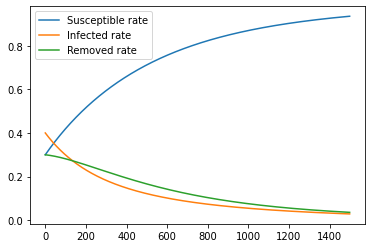

In [ ]:
SIRS_env = SIRS(coef=coef,deltat=dt,n_samples=ns,init_conditions=[0.3,0.4,0.3],plot=True)
_,_,_=SIRS_env.simulation()

In [ ]:
SIRS_env = SIRS(coef=coef,deltat=dt,n_samples=ns,init_conditions=[0.33,0.33,0.34],plot=True)
#_,_,_=SIRS_env.simulation()
SIRS_env.restart()
matriz = np.ones((4,4))-np.eye(4)
matriz[3,:]=0
dinamics = DTDRD(adj_matrix=matriz,epsilon=0.001,beta=1)
state = np.array([[0.33,0.33,0.34]]).T
target_policy = np.array([[0.4,0.4,0.2]]).T

steps_sim=200000
fit_vec=np.zeros((steps_sim,3))
state_vec=np.zeros((steps_sim,3))
epidemic_state=np.zeros((steps_sim,3))
target_vec = np.zeros((steps_sim,3))

change_target = True
for i in range(steps_sim):
    fit,ep = SIRS_env.fitness(state=state,target=target_policy)
    state = dinamics.step(state=np.append(state,0.0001).reshape(-1,1),fit=np.append(fit,SIRS_env.b).reshape(-1,1))
    state = state[:-1].reshape(-1,1)
    fit_vec[i,:]=fit.T-SIRS_env.b
    state_vec[i,:]=state.T
    epidemic_state[i,:]=ep.T
    target_vec[i,:]=target_policy.T
    if i%(steps_sim//10)==0:
        print('gamma: {} - beta: {} - zeta: {}'.format(SIRS_env.gamma,SIRS_env.beta,SIRS_env.zeta))
    if i%(steps_sim//2)==0 and i>0 and change_target:
        g = np.random.rand(3)*3
        target_policy= softmax(g).reshape(-1,1)   

gamma: 6.800000000000001 - beta: 6.6000000000000005 - zeta: 6.6000000000000005
gamma: 2.6823333750501 - beta: 12.06067272227447 - zeta: 5.25736308476424
gamma: 3.053523536484646 - beta: 12.781159627616452 - zeta: 4.165716093102279
gamma: 3.0896120945258794 - beta: 12.734302010539597 - zeta: 4.17647804358874
gamma: 3.091030831681114 - beta: 12.727770665070523 - zeta: 4.181589871996243
gamma: 3.090990145647561 - beta: 12.727446947726369 - zeta: 4.1819542430025
gamma: 3.0334811911389465 - beta: 16.969947557584028 - zeta: 0.0019100669896965846
gamma: 2.905888179223457 - beta: 17.102375101646658 - zeta: 2.374345317082173e-05
gamma: 2.904952258961929 - beta: 17.106206233319774 - zeta: 3.1958240548461645e-07
gamma: 2.904860852033029 - beta: 17.109168548564817 - zeta: 4.308200888926301e-09


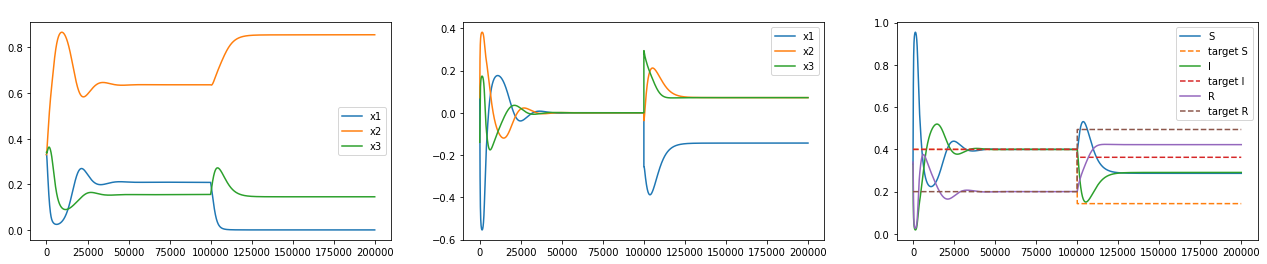

In [ ]:
plt.subplots(1,3,figsize=(22,4))

plt.subplot(131)
plt.plot(state_vec[:,0],label='x1')
plt.plot(state_vec[:,1],label='x2')
plt.plot(state_vec[:,2],label='x3')
plt.title('Inversiones',color='white')
plt.legend()
#plt.xlim([1,10000])

plt.subplot(132)
plt.plot(fit_vec[:,0],label='x1')
plt.plot(fit_vec[:,1],label='x2')
plt.plot(fit_vec[:,2],label='x3')
plt.title('Fitness',color='white')
plt.legend()
#plt.xlim([1,10000])

plt.subplot(133)
plt.plot(epidemic_state[:,0],label='S')
plt.plot(target_vec[:,0],'--',label='target S')
plt.plot(epidemic_state[:,1],label='I')
plt.plot(target_vec[:,1],'--',label='target I')
plt.plot(epidemic_state[:,2],label='R')
plt.plot(target_vec[:,2],'--',label='target R')
plt.title('SIRS',color='white')
plt.legend()
plt.savefig('AgenteGlobal2.png')
#plt.xlim([1,10000])

<Figure size 432x288 with 0 Axes>

# Modelo Personas

## SIRS personas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

class SIRS_Micro:

    def __init__(self,coef,n_samples=100,deltat=0.01,init_conditions=[0.1,0.6,0.3],plot=True,num_global_strategies=3,num_agents=1):

        self.coef = coef
        self.beta = coef['beta'] #tasa de infección
        self.mu = coef['mu'] #tasa de nacimiento
        self.alpha = coef['alpha'] #tasa de muerte
        self.gamma = coef['gamma'] #tasa de recuperacion 
        self.zeta = coef['zeta'] #tasa de perdida de la inmunidad
        self.deltat=deltat
        self.n_samples=n_samples
        self.S=init_conditions[0]
        self.I=init_conditions[1]
        self.R=init_conditions[2]
        self.init_conditions = init_conditions
        self.plot=plot
        self.error_window=[]
        self.intparam = np.zeros((3,1))
        self.MAcoefficent = 0.9999
        self.num_agents=num_agents
        self.b = 2
        self.convex_param = 0.6

        #self.theta = np.random.randint(low=1,high=10,size=(3,num_global_strategies))
        #self.theta = (self.theta.T/self.theta.max(axis=1)).T

        self.theta = np.array([[1,0,0],[0,1,0],[0,0,1]])
    
    def step(self):
        self.S=self.S+(self.mu-self.beta*self.S*self.I+self.R*self.zeta-self.S*self.alpha)*self.deltat
        self.I=self.I+(self.beta*self.S*self.I-self.gamma*self.I-self.alpha*self.I)*self.deltat
        self.R=self.R+(self.gamma*self.I-self.zeta*self.R-self.alpha*self.R)*self.deltat

    def restart(self,new_start=None):
        if new_start != None:
            self.S=new_start[0]
            self.I=new_start[1]
            self.R=new_start[2]
            self.init_conditions = new_start
        else:
            self.S=self.init_conditions[0]
            self.I=self.init_conditions[1]
            self.R=self.init_conditions[2]
        self.beta = self.coef['beta'] #tasa de infección
        self.mu = self.coef['mu'] #tasa de nacimiento
        self.alpha = self.coef['alpha'] #tasa de muerte
        self.gamma = self.coef['gamma'] #tasa de recuperacion 
        self.zeta = self.coef['zeta'] #tasa de perdida de la inmunidad

    def simulation(self,new_start=None):
        self.restart(new_start=new_start)
        S_vec = np.zeros((self.n_samples,1))
        S_vec[0]=self.S
        I_vec = np.zeros((self.n_samples,1))
        I_vec[0]=self.I
        R_vec = np.zeros((self.n_samples,1))
        R_vec[0]=self.R

        for k in range(self.n_samples-1):
            self.step()
            S_vec[k+1]=self.S
            I_vec[k+1]=self.I
            R_vec[k+1]=self.R

        if self.plot:
            plt.plot(S_vec,label='Susceptible rate')
            plt.plot(I_vec,label='Infected rate')
            plt.plot(R_vec,label='Removed rate')
            plt.legend()
        return (S_vec,I_vec,R_vec)

    def update_parameters(self,macro_state,state_g):
        #gamma sube R, beta sube I, zeta sube S
        delay = 30 #esto es porque asumo que el efecto de las inversiones no es inmediato 

        delta_update = (self.convex_param*macro_state+(1-self.convex_param)*state_g)*delay
        self.gamma=delta_update[2,0]
        self.beta=delta_update[1,0]
        self.zeta=delta_update[0,0]

    def fitness(self,state,target):
        self.step()
        We2f = np.array([[1,0,0],[0,1,0],[0,0,1]])
        epidemic_state=np.array([[self.S,self.I,self.R]]).T
        error=target-epidemic_state+self.b
        fitness = np.dot(We2f,error)
        return fitness,epidemic_state

## Modelo agentes

In [ ]:
class Agent: 
    def __init__(self,num_strategies=5,target_policy=None,control_agente=None,sim_steps=100,agent_dummy=False):
        self.Dx = num_strategies
        #self.Wx = np.random.randint(low=0,high=11,size=(num_strategies,num_strategies))/10
        self.Wx = np.eye(num_strategies)
        self.state = np.ones((num_strategies,1))/(num_strategies)
        if target_policy!=None:
            g = np.random.rand(num_strategies)*3
            self.target = softmax(g).reshape(-1,1)
        else:
            self.target = np.ones((num_strategies,1))/num_strategies
        self.modified_target = self.target
        self.fitness = np.ones((num_strategies,1))/num_strategies
        self.convex_param = np.random.random()
        #self.convex_param = 1
        self.Wg=None
        self.control = control_agente
        self.b=1
        self.dummy = pow(10,-6)
        self.agent_dummy=agent_dummy
        if agent_dummy:
            self.state[0,0]-=self.dummy
        self.initialize_Wg()



        print('----init agent----')
        print('lambda: ',self.convex_param)


    def predict(self,state):
        return np.dot(self.Wx,state)
    
    def initialize_Wg(self,num_global_strategies=3):
        #self.Wg = np.random.randint(10,size=(self.Dx,num_global_strategies))/10
        self.Wg = np.array([[0,1,0],[1/3,1/3,1/3],[0,1,0],[0,0,1]])
        #print('-----Wg-----')
        #print(self.Wg)

    def modify_target(self,incentive):
        transform_incentive = np.dot(self.Wg,incentive)
        transform_incentive=softmax(transform_incentive)
        self.modified_target=self.convex_param*transform_incentive+self.target*(1-self.convex_param)
    
    def calculate_macro_state(self):
        S = self.state[1,0]
        I = -self.state[0,0]+self.state[2,0]
        R = self.state[3,0]
        return np.array([S,I,R]).reshape(-1,1)
    
    def calculate_fitness(self):
        yx = self.predict(self.state)
        self.fitness=self.modified_target-yx+self.b
        return self.fitness
    
    def update(self,new_state):
        self.state=new_state
    
    def reset(self):
        self.state = np.ones((self.Dx,1))/self.Dx
        self.modified_target = self.target
        self.fitness = np.ones((self.Dx,1))/self.Dx
    
    def step_sim(self,printp=False,dummy_fit=False):
        fit_agent=agent.calculate_fitness()
        yx = self.predict(self.state)

        if dummy_fit:
            state_agent = self.control.step(state=np.append(self.state,self.dummy).reshape(-1,1),fit=np.append(fit_agent,self.b).reshape(-1,1),printp=printp)
            if self.agent_dummy:
                self.dummy=state_agent[-1]
            self.update(state_agent[:-1].reshape(-1,1))
        else:
            state_agent = self.control.step(state=self.state,fit=fit_agent,printp=printp)
            self.dummy=state_agent[-1]
            self.update(state_agent)
        return yx.T,fit_agent.T


## simulación

### simulacion agente solo

In [ ]:
matriz = np.ones((6,6))-np.eye(6)
# matriz[5,:]=0
control = DTDRD(adj_matrix=matriz,epsilon=0.1)

In [ ]:
agent = Agent(control_agente=control,agent_dummy=True)
agent.initialize_Wg()
steps_sim=20000
fit_vec_pop=np.zeros((steps_sim,5))
state_vec_pop=np.zeros((steps_sim,5))
target_vec_pop = np.zeros((steps_sim,5))
yx_vec_pop = np.zeros((steps_sim,5)) 
printp=False
change_target = False
g = np.random.rand(5)*3
agent.modified_target= softmax(g).reshape(-1,1)
for i in range(steps_sim):
    yx_agent,fit_agent=agent.step_sim(dummy_fit=True,printp=printp)
    yx_vec_pop[i,:]=yx_agent
    fit_vec_pop[i,:]=fit_agent-agent.b
    state_vec_pop[i,:]=agent.state.T
    target_vec_pop[i,:]=agent.modified_target.T
    printp=False
    if i%(steps_sim//2)==0 and i>0 and change_target:
        g = np.random.rand(5)*3
        agent.modified_target= softmax(g).reshape(-1,1)
    if i ==1500000:
        printp=True

----init agent----
lambda:  1


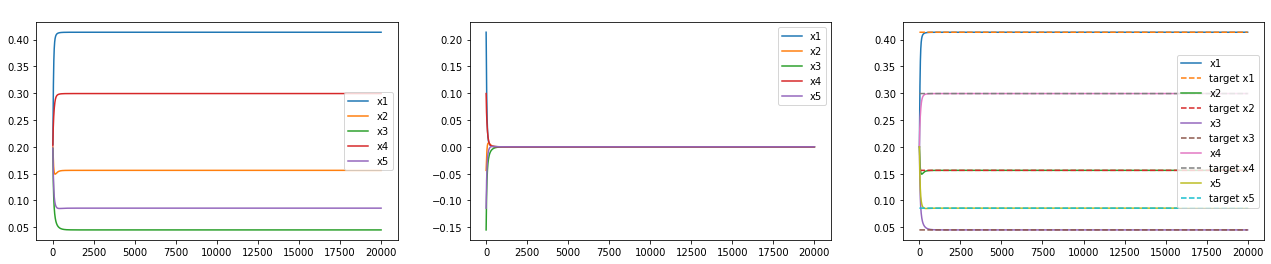

In [ ]:
plt.subplots(1,3,figsize=(22,4))

plt.subplot(131)
plt.plot(state_vec_pop[:,0],label='x1')
plt.plot(state_vec_pop[:,1],label='x2')
plt.plot(state_vec_pop[:,2],label='x3')
plt.plot(state_vec_pop[:,3],label='x4')
plt.plot(state_vec_pop[:,4],label='x5')
plt.title('Inversiones',color='white')
plt.legend()

#plt.xlim([1,10000])

plt.subplot(132)
plt.plot(fit_vec_pop[:,0],label='x1')
plt.plot(fit_vec_pop[:,1],label='x2')
plt.plot(fit_vec_pop[:,2],label='x3')
plt.plot(fit_vec_pop[:,3],label='x4')
plt.plot(fit_vec_pop[:,4],label='x5')
plt.title('Fitness',color='white')
plt.legend()

plt.subplot(133)
plt.plot(yx_vec_pop[:,0],label='x1')
plt.plot(target_vec_pop[:,0],'--',label='target x1')

plt.plot(yx_vec_pop[:,1],label='x2')
plt.plot(target_vec_pop[:,1],'--',label='target x2')

plt.plot(yx_vec_pop[:,2],label='x3')
plt.plot(target_vec_pop[:,2],'--',label='target x3')

plt.plot(yx_vec_pop[:,3],label='x4')
plt.plot(target_vec_pop[:,3],'--',label='target x4')

plt.plot(yx_vec_pop[:,4],label='x5')
plt.plot(target_vec_pop[:,4],'--',label='target x5')
plt.title('felicidad',color='white')
plt.legend()
#plt.xlim([1,10000])


### simulacion global

In [ ]:
matriz_agente = np.ones((5,5))-np.eye(5)
control_agente = DTDRD(adj_matrix=matriz_agente,epsilon=0.01)
#matriz_agente[4,:]=0

matriz_global = np.ones((3,3))-np.eye(3)
#matriz_global[3,:]=0
control_global = DTDRD(adj_matrix=matriz_global,epsilon=0.005)

In [ ]:
coef={'beta':3,
      'gamma':2,
      'mu':2,
      'zeta':1,
      'alpha':2}
dt = 0.001
ns= 10000
num_agents=5

SIRS_env = SIRS_Micro(coef=coef,deltat=dt,n_samples=ns,init_conditions=[0.33,0.33,0.34],plot=True,num_agents=num_agents)
#_,_,_=SIRS_env.simulation()
#SIRS_env.restart()

state_global = np.array([[0.33,0.33,0.34]]).T
global_target_policy = np.array([[0.33,0.44,0.24]]).T

agents = [Agent(control_agente=control_agente,target_policy='rand',num_strategies=4,agent_dummy=True) for i in range(num_agents)]

steps_sim=200000

fit_vec_pop = np.zeros((num_agents,steps_sim,agents[0].Dx))
fit_vec_global = np.zeros((steps_sim,3))

state_vec_pop=np.zeros((num_agents,steps_sim,agents[0].Dx))
state_vec_global = np.zeros((steps_sim,3))

target_vec_pop = np.zeros((num_agents,steps_sim,agents[0].Dx))
target_vec_global = np.zeros((steps_sim,3))

yx_vec_pop = np.zeros((num_agents,steps_sim,agents[0].Dx)) 
epidemic_state_global = np.zeros((steps_sim,3))
printp=False
change_target = True
dummy_global = 0.00001
for i in range(steps_sim):
    #actualización global
    fit_global,ep = SIRS_env.fitness(state=state_global,target=global_target_policy)
    state_global = control_global.step(state=state_global,fit=fit_global,printp=False)

    # state_global = control_global.step(state=np.append(state_global,dummy_global).reshape(-1,1),fit=np.append(fit_global,SIRS_env.b).reshape(-1,1),printp=False)
    # dummy_global = state_global[-1]
    # state_global = state_global[:-1].reshape(-1,1)

    fit_vec_global[i,:]=fit_global.T-SIRS_env.b
    state_vec_global[i,:]=state_global.T
    epidemic_state_global[i,:]=ep.T
    target_vec_global[i,:]=global_target_policy.T

    macro_state=np.zeros((3,1))
    index_agent=0
    #actualización agente
    for agent in agents:
        yx_agent,fit_agent=agent.step_sim(dummy_fit=True,printp=printp)
        yx_vec_pop[index_agent,i,:]=yx_agent
        fit_vec_pop[index_agent,i,:]=fit_agent-agent.b
        state_vec_pop[index_agent,i,:]=agent.state.T
        target_vec_pop[index_agent,i,:]=agent.target.T
        macro_state += agent.calculate_macro_state()

        index_agent+=1
        #envio de incentivos
        if np.abs(agent.fitness-agent.b).mean()<0.1 and i>0:
            incentive = state_global*fit_global
            agent.modify_target(incentive)
        
    macro_state=macro_state/len(agents)
    #actualización paramateros SIRS
    SIRS_env.update_parameters(macro_state,state_global)

    if i%(steps_sim//2)==0 and i>0 and change_target:
        g = np.random.rand(3)*3
        global_target_policy = softmax(g).reshape(-1,1)
    printp=False
    if i%(steps_sim//4)==0:
        print('Iteración: ',i)
    if i==400000000:
        printp=True

----init agent----
lambda:  0.8387235565409354
----init agent----
lambda:  0.6083893463602015
----init agent----
lambda:  0.33692637632924094
----init agent----
lambda:  0.01675525078191742
----init agent----
lambda:  0.33576129304869073
Iteración:  0
Iteración:  50000
Iteración:  100000
Iteración:  150000


In [ ]:
SIRS_env.gamma,SIRS_env.beta,SIRS_env.zeta

(6.678883382174263, 9.000089999999602, 15.063761970699154)

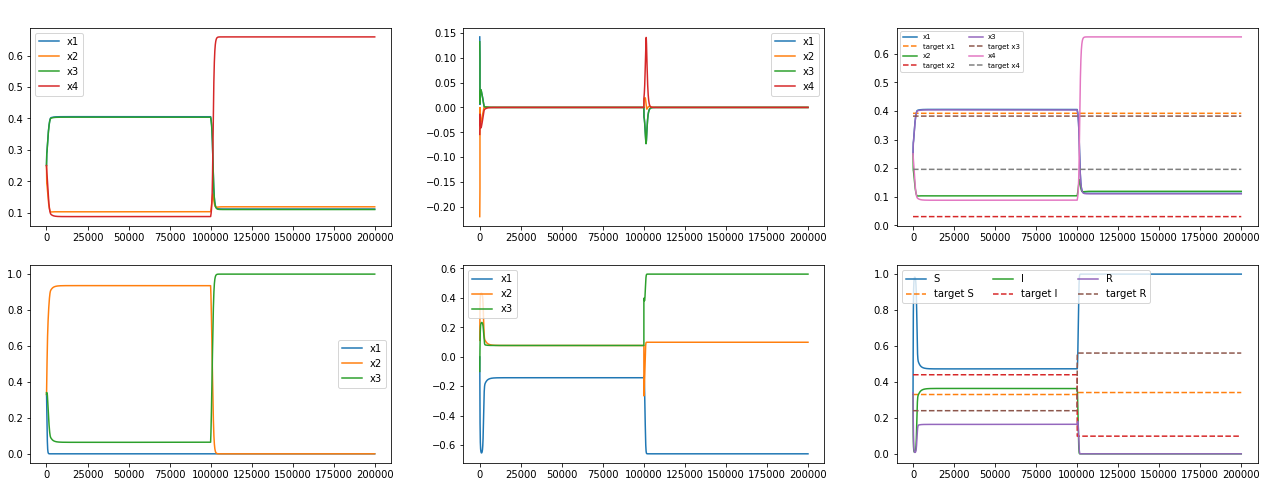

In [ ]:
plot_sim(index_agent=0)

In [ ]:
(SIRS_env.convex_param*macro_state+(1-SIRS_env.convex_param)*state_global)*10

array([[0.56933906],
       [3.17083172],
       [0.17109605]])

In [ ]:
def plot_sim(index_agent=1):
    plt.subplots(2,3,figsize=(22,8))

    plt.subplot(2,3,1)
    plt.plot(state_vec_pop[index_agent,:,0],label='x1')
    plt.plot(state_vec_pop[index_agent,:,1],label='x2')
    plt.plot(state_vec_pop[index_agent,:,2],label='x3')
    plt.plot(state_vec_pop[index_agent,:,3],label='x4')
    plt.title('Inversiones Agente',color='white')
    plt.legend()
    #plt.xlim([1,10000])

    plt.subplot(2,3,2)
    plt.plot(fit_vec_pop[index_agent,:,0],label='x1')
    plt.plot(fit_vec_pop[index_agent,:,1],label='x2')
    plt.plot(fit_vec_pop[index_agent,:,2],label='x3')
    plt.plot(fit_vec_pop[index_agent,:,3],label='x4')
    plt.title('Fitness Agente',color='white')
    plt.legend()

    plt.subplot(2,3,3)
    plt.plot(yx_vec_pop[index_agent,:,0],label='x1')
    plt.plot(target_vec_pop[index_agent,:,0],'--',label='target x1')

    plt.plot(yx_vec_pop[index_agent,:,1],label='x2')
    plt.plot(target_vec_pop[index_agent,:,1],'--',label='target x2')

    plt.plot(yx_vec_pop[index_agent,:,2],label='x3')
    plt.plot(target_vec_pop[index_agent,:,2],'--',label='target x3')

    plt.plot(yx_vec_pop[index_agent,:,3],label='x4')
    plt.plot(target_vec_pop[index_agent,:,3],'--',label='target x4')
    plt.title('$\hat{Y}$',color='white')
    plt.legend(ncol=2,fontsize=7)
    #plt.xlim([1,10000])


    plt.subplot(2,3,4)
    plt.plot(state_vec_global[:,0],label='x1')
    plt.plot(state_vec_global[:,1],label='x2')
    plt.plot(state_vec_global[:,2],label='x3')
    plt.title('Inversiones G',color='white')
    plt.legend()
    #plt.xlim([1,10000])

    plt.subplot(2,3,5)
    plt.plot(fit_vec_global[:,0],label='x1')
    plt.plot(fit_vec_global[:,1],label='x2')
    plt.plot(fit_vec_global[:,2],label='x3')
    plt.title('Fitness G',color='white')
    plt.legend()
    # #plt.xlim([1,10000])

    plt.subplot(2,3,6)
    plt.plot(epidemic_state_global[:,0],label='S')
    plt.plot(target_vec_global[:,0],'--',label='target S')

    plt.plot(epidemic_state_global[:,1],label='I')
    plt.plot(target_vec_global[:,1],'--',label='target I')

    plt.plot(epidemic_state_global[:,2],label='R')
    plt.plot(target_vec_global[:,2],'--',label='target R')

    plt.title('SIRS',color='white')
    plt.legend(ncol=3)

    plt.savefig('MultiAgenteLambda06.png')
    # #plt.xlim([1,10000])